In [ ]:
from PySDM_examples.Hill_et_al_2023.alpha_settings_run import Settings, Simulation
from PySDM_examples.Hill_et_al_2023.cross_sections import *
from PySDM_examples.Shipway_and_Hill_2012.plot import plot
from PySDM.physics import si
from PySDM.exporters import NetCDFExporter_1d
import matplotlib.pyplot as plt
import numpy as np
from PySDM.backends import CPU
from open_atmos_jupyter_utils import show_plot


In [20]:
# Things to check before comparing results:
# Cloud droplet size starts at 2um like in the 2023 paper (the other Shipway + Hill folder starts at 1um)
# Nd, D_vol and sigma values are computed using only > cloud size
# However LWC and LWP contain unactivated liquid sizes.. hm this might go into D_vol too

In [21]:
common_params = {
    "n_sd_per_gridbox": 256,
    "dt": 5 * si.s,
    "dz": 50 * si.m,
    "p0": 1000 * si.hPa,
    "kappa": .9,
    "rho_times_w_1": 3 * si.kg / si.m**3,
    'save_spec_and_attr_times':np.linspace(0,3600,721),
}
# if 'CI' in os.environ:
#     common_params["t_max"] = 10 * common_params["dt"]
#     common_params["n_sd_per_gridbox"] = 16 

output = {}
settings = {}
simulation = {}

precips = (True, False)
alphas = (0,)
aerosol_concs = (50,150,300)
n_iters = 10

In [22]:
backend = CPU()
for precip in precips:
    for na in aerosol_concs:
        for alpha in alphas:
            for i in range(n_iters):
                key = f"na={na}p={precip}_alpha={alpha}_{i}"
                settings[key] = Settings(
                    **common_params,
                    particles_per_volume_STP=na * si.cm**-3,
                    precip=precip,
                    alpha=alpha
                )
                backend.formulae.seed = i
                simulation[key] = Simulation(settings[key], backend=backend)
                output[key] = simulation[key].run().products

/Users/emmaware/PySDM/PySDM/backends/numba.py:48: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


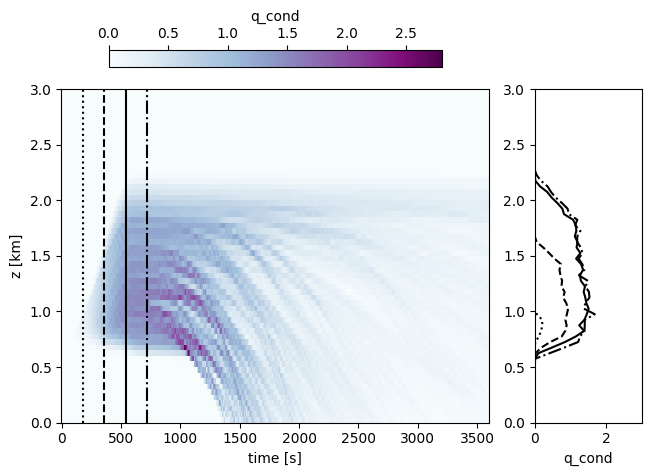

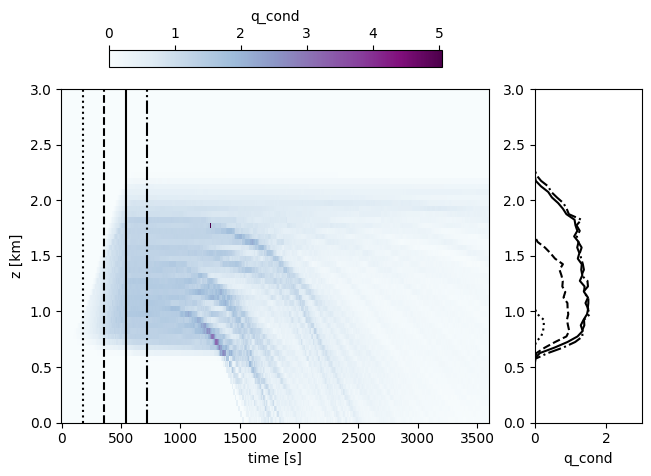

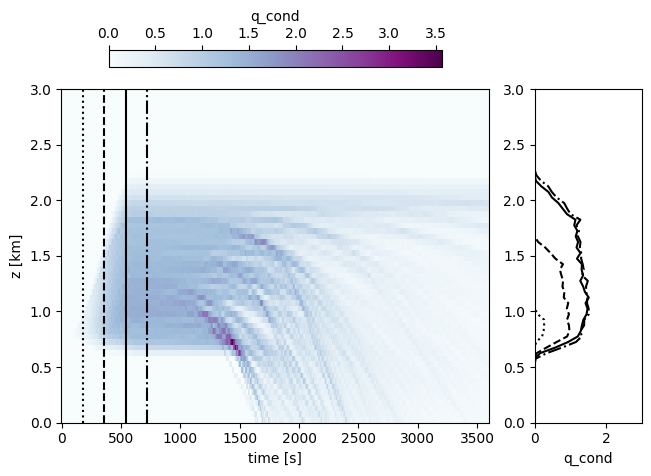

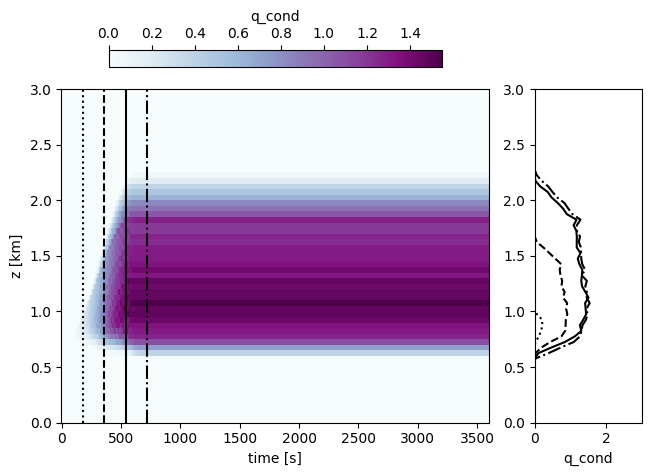

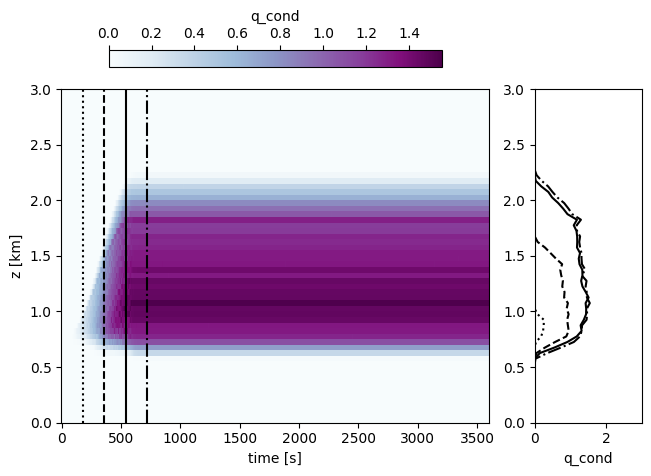

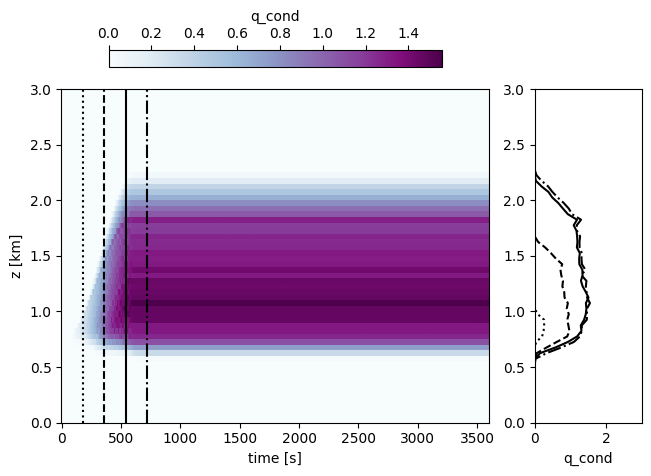

In [23]:
for precip in precips:
    for na in aerosol_concs:
        for alpha in alphas:
            key = f"na={na}p={precip}_alpha={alpha}_0"
            output[key]["q_cond"] = output[key]["cloud water mixing ratio"] + output[key]["rain water mixing ratio"]
line = {3: ':', 6: '--', 9: '-', 12: '-.'}
for p in precips:
    for na in aerosol_concs:
        for alpha in alphas:
            key = f"na={na}p={p}_alpha={alpha}_0"
            plot(var='q_cond', qlabel='q_cond', fname=f'{key}.pdf',
                output=output[key],line=line,ax2_xlims=(0,3))

In [24]:
above_ground = np.where(output[key]["z"] > 0)[0]
cloud_base = np.where(output[key]["z"] == 675)[0][0]
mosaic_row = lambda name: [f"{name}_{na}" for na in aerosol_concs]

def plot_mosaic(ax, data, axlabel, unit,logy=False,logx=False,type='time',label=None):
    if type == 'time':
        ax.plot(output[key]["t"]*si.s, data,label=label)
        ax.set_ylabel(axlabel + f' [{unit}]')
        ax.set_xlabel('time [s]')
    else:
        ax.plot(data, output[key]["z"][above_ground] / si.km, label=label)
        ax.set_xlabel(axlabel + f' [{unit}]')
        ax.set_ylabel('height [km]')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')

def plot_mosaic_fill_between(ax, data,std,axlabel, unit, logy=False, logx=False, type='time'):
    if type == 'time':
        ax.fill_between(output[key]["t"]*si.s, data-std, data+std, alpha=0.5)
        ax.set_ylabel(axlabel + f' [{unit}]')
        ax.set_xlabel('time [s]')
    else:
        ax.fill_betweenx(output[key]["z"][above_ground] / si.km, data-std, data+std, alpha=0.5)
        ax.set_xlabel(axlabel + f' [{unit}]')
        ax.set_ylabel('height [km]')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')

/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:49: RuntimeWarning: Mean of empty slice
  mean_num_conc = np.nanmean(masked, axis=0)
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:8: RuntimeWarning: divide by zero encountered in divide
  D_vol = (6 * output["LWC"][cloud_base]/(np.pi * num_conc * 1000)) ** (1/3)
/Users/emmaware/PySDM/venv/lib/python3.9/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


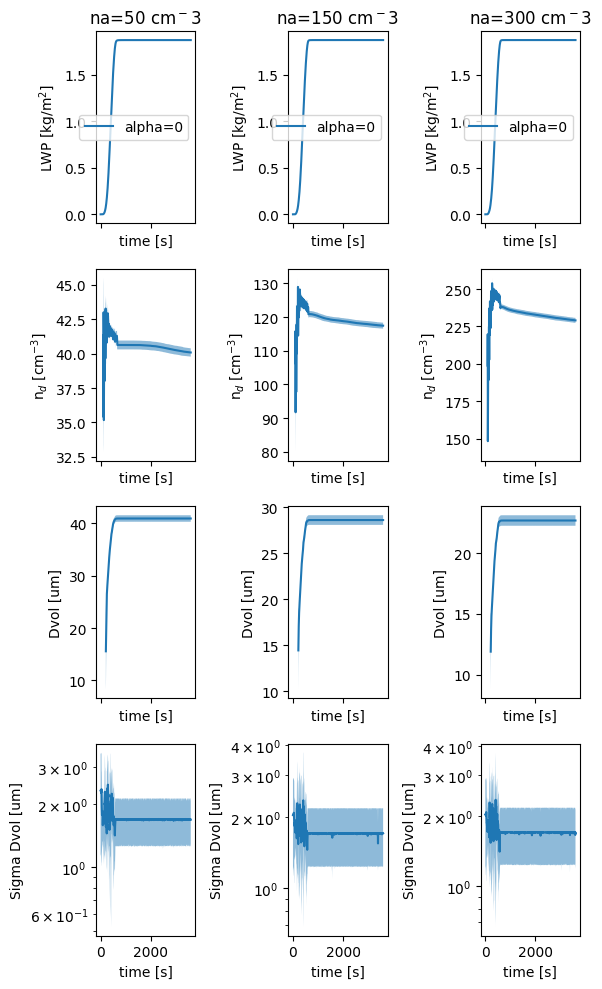

In [32]:
#fig_1: time series no precip
time_mosaic = [
    mosaic_row("LWP"),
    mosaic_row("nc"),
    mosaic_row("Dvol"),
    mosaic_row("sigma"),
]

fig, axes = plt.subplot_mosaic(time_mosaic, figsize=(6, 10),sharex=True, tight_layout=True)

for na in aerosol_concs:
    for alpha in alphas:
        LWP_iters = []
        mean_num_conc_iters = []
        D_vol_iters = []
        sigma_iters = []
        for i in range(n_iters):
            key = f"na={na}p=False_alpha={alpha}_{i}"
    
            LWP_i, mean_num_conc_i = compute_LWP_and_nc_time_series(output[key],settings[key], above_ground)
            mean_num_conc_i = mean_num_conc_i / si.cm**-3

            # Computed at max LWC height? the other plot is at cloud base, ~700 m (675 m here bc of indexing)
            max_LWC_height_i = np.where(output[key]["LWC"] == np.max(output[key]["LWC"]))[0][0]
            D_vol_i, sigma_i = compute_dvol_andsigma_time_series(output[key],settings[key], max_LWC_height_i)
            D_vol_i = D_vol_i / si.um
            sigma_i = sigma_i / si.um
            LWP_iters.append(LWP_i)
            mean_num_conc_iters.append(mean_num_conc_i)
            D_vol_iters.append(D_vol_i)
            sigma_iters.append(sigma_i)

        LWP = np.mean(LWP_iters, axis=0)
        mean_num_conc = np.mean(mean_num_conc_iters, axis=0)
        D_vol = np.mean(D_vol_iters, axis=0)        
        sigma = np.mean(sigma_iters, axis=0)
        #standard deviation
        LWP_std = np.std(LWP_iters, axis=0)
        mean_num_conc_std = np.std(mean_num_conc_iters, axis=0)
        D_vol_std = np.std(D_vol_iters, axis=0)
        sigma_std = np.std(sigma_iters, axis=0)

        plot_mosaic(axes[f"LWP_{na}"], LWP, "LWP", "kg/m$^2$",label=f"alpha={alpha}")
        plot_mosaic(axes[f"nc_{na}"], mean_num_conc, "n$_d$", "cm$^{-3}$",label=f"alpha={alpha}")
        plot_mosaic(axes[f"Dvol_{na}"], D_vol, "Dvol", "um",label=f"alpha={alpha}")
        plot_mosaic(axes[f"sigma_{na}"], sigma, "Sigma Dvol", "um", logy=True,label=f"alpha={alpha}")
        plot_mosaic_fill_between(axes[f"LWP_{na}"], LWP,LWP_std, "LWP", "kg/m$^2$")
        plot_mosaic_fill_between(axes[f"nc_{na}"], mean_num_conc,mean_num_conc_std, "n$_d$", "cm$^{-3}$")
        plot_mosaic_fill_between(axes[f"Dvol_{na}"], D_vol,D_vol_std, "Dvol", "um")
        plot_mosaic_fill_between(axes[f"sigma_{na}"], sigma,sigma_std, "Sigma Dvol", "um", logy=True)

        axes[f"LWP_{na}"].set_title(f"na={na} cm$ ^{-3}$")
        axes[f"LWP_{na}"].legend()

show_plot(filename="Fig1nsd256.pdf", inline_format="png")


/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:27: RuntimeWarning: divide by zero encountered in divide
  D_vol = (6 * output["LWC"][zslice, t_idx] / (np.pi * num_conc * 1000)) ** (1/3)
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:27: RuntimeWarning: invalid value encountered in divide
  D_vol = (6 * output["LWC"][zslice, t_idx] / (np.pi * num_conc * 1000)) ** (1/3)
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:35: RuntimeWarning: invalid value encountered in divide
  Dvolmass = np.sum(mass_bins * Dk,axis=1) / np.sum(mass_bins,axis=1)
/Users/emmaware/PySDM/venv/lib/python3.9/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


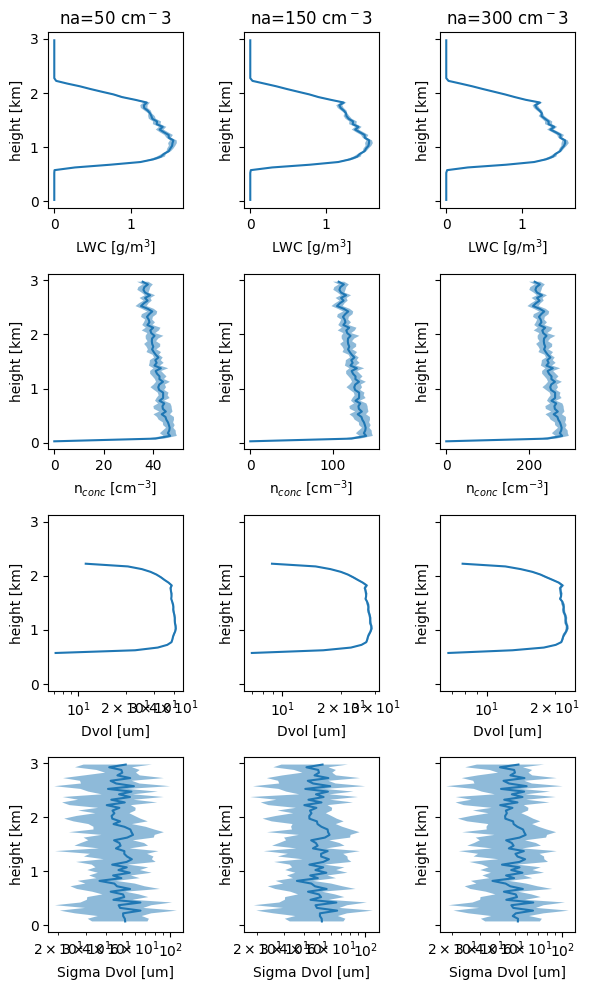

In [33]:
#fig_2: vertical profiles no precip
t_slice = 600 * si.s 
vertical_mosaic = [
    mosaic_row("LWC"),
    mosaic_row("nc"),
    mosaic_row("Dvol"),
    mosaic_row("sigma"),
]
fig, axes = plt.subplot_mosaic(vertical_mosaic, figsize=(6, 10),sharey=True,tight_layout=True)

for na in aerosol_concs:
    for alpha in alphas:
        LWC_iters = []
        num_conc_vertical_iters = []
        D_vol_iters = []
        sigma_vertical_iters = []

        for i in range(n_iters):

            key = f"na={na}p=False_alpha={alpha}_{i}"

            LWC_i,num_conc_vertical_i = compute_LWP_and_nc_vertical(output[key], above_ground, t_slice)
            LWC_i = LWC_i / si.g # kg ->g
            num_conc_vertical_i = num_conc_vertical_i / si.cm**-3
            D_vol_vertical_i, sigma_vertical_i = compute_dvol_andsigma_vertical(output[key],settings[key], above_ground, t_slice)
            D_vol_vertical_i = D_vol_vertical_i / si.um
            sigma_vertical_i = sigma_vertical_i / si.um
            LWC_iters.append(LWC_i)
            num_conc_vertical_iters.append(num_conc_vertical_i)
            D_vol_iters.append(D_vol_vertical_i)
            sigma_vertical_iters.append(sigma_vertical_i)
        LWC = np.mean(LWC_iters, axis=0)
        num_conc_vertical = np.mean(num_conc_vertical_iters, axis=0)        
        D_vol_vertical = np.mean(D_vol_iters, axis=0)        
        sigma_vertical = np.mean(sigma_vertical_iters, axis=0)
        LWC_std = np.std(LWC_iters, axis=0)
        num_conc_vertical_std = np.std(num_conc_vertical_iters, axis=0)
        D_vol_std = np.std(D_vol_iters, axis=0)
        sigma_std = np.std(sigma_vertical_iters, axis=0)
        plot_mosaic(axes[f"LWC_{na}"], LWC, "LWC", "g/m$^3$", type='vertical',label=f"alpha={alpha}")
        plot_mosaic(axes[f"nc_{na}"], num_conc_vertical, "n$_{conc}$", "cm$^{-3}$", type='vertical',label=f"alpha={alpha}")
        plot_mosaic(axes[f"Dvol_{na}"], D_vol_vertical, "Dvol", "um", logx=True, type='vertical', label=f"alpha={alpha}")
        plot_mosaic(axes[f"sigma_{na}"], sigma_vertical, "Sigma Dvol", "um", logx=True, type='vertical', label=f"alpha={alpha}")
        plot_mosaic_fill_between(axes[f"LWC_{na}"], LWC, LWC_std, "LWC", "g/m$^3$", type='vertical')
        plot_mosaic_fill_between(axes[f"nc_{na}"], num_conc_vertical, num_conc_vertical_std, "n$_{conc}$", "cm$^{-3}$", type='vertical')
        plot_mosaic_fill_between(axes[f"Dvol_{na}"], D_vol_vertical, D_vol_std, "Dvol", "um", logx=True, type='vertical')
        plot_mosaic_fill_between(axes[f"sigma_{na}"], sigma_vertical, sigma_std, "Sigma Dvol", "um", logx=True, type='vertical')

        axes[f"LWC_{na}"].set_title(f"na={na} cm$ ^{-3}$")

show_plot(filename=f"Fig2nsd=256.pdf", inline_format="png")

/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:49: RuntimeWarning: Mean of empty slice
  mean_num_conc = np.nanmean(masked, axis=0)
/Users/emmaware/PySDM/examples/PySDM_examples/Hill_et_al_2023/cross_sections.py:8: RuntimeWarning: divide by zero encountered in divide
  D_vol = (6 * output["LWC"][cloud_base]/(np.pi * num_conc * 1000)) ** (1/3)
/Users/emmaware/PySDM/venv/lib/python3.9/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


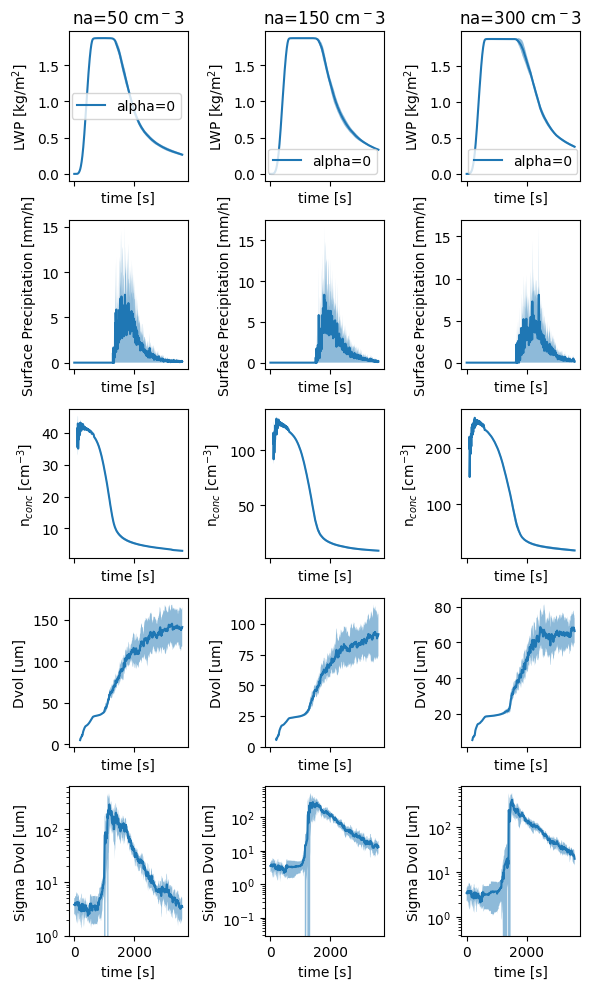

In [34]:
#fig_4: time series precip
time_mosaic = [
    mosaic_row("LWP"),
    mosaic_row("surface_precip"),
    mosaic_row("nc"),
    mosaic_row("Dvol"),
    mosaic_row("sigma"),
]
fig, axes = plt.subplot_mosaic(time_mosaic, figsize=(6, 10),sharex=True,tight_layout=True)

for na in aerosol_concs:
    for alpha in alphas:
        LWP_iters = []
        mean_num_conc_iters = []
        D_vol_iters = []
        sigma_iters = []
        surface_precip_iters = []
        for i in range(n_iters):
            key = f"na={na}p=True_alpha={alpha}_{i}"
    
            LWP_i, mean_num_conc_i = compute_LWP_and_nc_time_series(output[key],settings[key], above_ground)
            mean_num_conc_i = mean_num_conc_i / si.cm**-3


            surface_precip_i = output[key]['surface precipitation']* si.hour/si.mm
            D_vol_i, sigma_i = compute_dvol_andsigma_time_series(output[key],settings[key], cloud_base)
            D_vol_i = D_vol_i / si.um
            sigma_i = sigma_i / si.um
            LWP_iters.append(LWP_i)
            surface_precip_iters.append(surface_precip_i)
            mean_num_conc_iters.append(mean_num_conc_i)
            D_vol_iters.append(D_vol_i)
            sigma_iters.append(sigma_i)

        LWP = np.mean(LWP_iters, axis=0)
        surface_precip = np.mean(surface_precip_iters, axis=0)
        mean_num_conc = np.mean(mean_num_conc_iters, axis=0)        
        D_vol = np.mean(D_vol_iters, axis=0)        
        sigma = np.mean(sigma_iters, axis=0)
        #standard deviation
        LWP_std = np.std(LWP_iters, axis=0)
        mean_num_conc_std = np.std(mean_num_conc_iters, axis=0)     
        D_vol_std = np.std(D_vol_iters, axis=0)
        sigma_std = np.std(sigma_iters, axis=0)
        surface_precip_std = np.mean(surface_precip_iters, axis=0)

        plot_mosaic(axes[f"LWP_{na}"], LWP, "LWP", "kg/m$^2$", label=f"alpha={alpha}")
        plot_mosaic(axes[f"surface_precip_{na}"], surface_precip, "Surface Precipitation", "mm/h", label=f"alpha={alpha}")
        plot_mosaic(axes[f"nc_{na}"], mean_num_conc, "n$_{comc}$", "cm$^{-3}$", label=f"alpha={alpha}")
        plot_mosaic(axes[f"Dvol_{na}"], D_vol, "Dvol", "um", label=f"alpha={alpha}")
        plot_mosaic(axes[f"sigma_{na}"], sigma, "Sigma Dvol", "um", logy=True, label=f"alpha={alpha}")
        plot_mosaic_fill_between(axes[f"LWP_{na}"], LWP,LWP_std, "LWP", "kg/m$^2$")
        plot_mosaic_fill_between(axes[f"surface_precip_{na}"], surface_precip,surface_precip_std, "Surface Precipitation", "mm/h")
        plot_mosaic_fill_between(axes[f"nc_{na}"], mean_num_conc,mean_num_conc_std, "n$_{conc}$", "cm$^{-3}$")
        plot_mosaic_fill_between(axes[f"Dvol_{na}"], D_vol,D_vol_std, "Dvol", "um")
        plot_mosaic_fill_between(axes[f"sigma_{na}"], sigma,sigma_std, "Sigma Dvol", "um", logy=True)

        axes[f"LWP_{na}"].set_title(f"na={na} cm$ ^{-3}$")
        axes[f"LWP_{na}"].legend()

show_plot(filename="Fig4nsd=256.pdf", inline_format="png")